In [24]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
import panel as pn
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets
from string import digits

pn.extension()

%matplotlib inline

In [25]:
# Read the Mapbox API key
mapbox_token = os.getenv("MAPBOX_API_KEY")
load_dotenv()

True

In [26]:
# Read the ATLAS data into a Pandas DataFrame
file_path = Path("Resources/Raw/ATLAS.csv")
ATLAS = pd.read_csv(file_path, index_col="Customers")
ATLAS.head()

,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service
Customers,,,,,,
Louisiana Board of Regents,3/20/2015,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16
Emporia State University,5/28/2015,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16
Morehouse State University,6/23/2015,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16
State University of NY Postdam,6/26/2015,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16
ST. Mary's College of Maryland,10/7/2015,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16


In [27]:
# Cleanup/preprocessing

## Cean up dates column (TODO functionalize)
dates_of_service = ATLAS.iloc[0:6]["Dates of service "]

start_date_list = []
end_date_list = []

for date_of_service_str in dates_of_service:
    split1 = date_of_service_str.find("Subscription")
    split2 = split1 + len("Subscription")
    date_range = date_of_service_str[split2:].strip()

    split1 = date_range.find("to")
    split2 = split1 + len("to")
    date1_str = date_range[0:split1].strip()
    date2_str = date_range[split2:].strip()

    #print(f"date1_str: {date1_str}  date2_str: {date2_str}")
    date1 = pd.Timestamp(date1_str, tz="America/New_York").isoformat()
    date2 = pd.Timestamp(date2_str, tz="America/New_York").isoformat()
    #print(f"date1_str: {date1_str}  date1: {date1}")
    #print(f"date2_str: {date2_str}  date2: {date2}")

    start_date_list.append(date1)
    end_date_list.append(date2)

dates_df = pd.DataFrame({"Start date":start_date_list,"End date": end_date_list})
dates_df.head()
ATLAS_with_fixed_dates = pd.concat([ATLAS.reset_index(), dates_df], axis='columns', join="inner")
ATLAS_with_fixed_dates.head()

,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Start date,End date
0,Louisiana Board of Regents,3/20/2015,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015-03-18T00:00:00-04:00,2016-06-30T00:00:00-04:00
1,Emporia State University,5/28/2015,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
2,Morehouse State University,6/23/2015,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015-06-10T00:00:00-04:00,2016-06-30T00:00:00-04:00
3,State University of NY Postdam,6/26/2015,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
4,ST. Mary's College of Maryland,10/7/2015,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015-10-05T00:00:00-04:00,2016-09-30T00:00:00-04:00


In [28]:
## Extract paying customers
#TODO Clean up customer names
paying_customers = ATLAS.reset_index()["Customers"].sort_values().drop_duplicates()
paying_customers.head()

129    Alabama A&M University-College of Education
146                        Albertus Magnus College
178                     Albuquerque Public Schools
114                       Alcorn State University 
635                  Alderson Broaddus University 
Name: Customers, dtype: object

In [29]:
def remove_strings_from_customer_names(original_customer_name):
    invalid_strings = ["pymt", "due"]
    for invalid_item in invalid_strings:
        original_customer_name = original_customer_name.replace(invalid_item, "")
    return original_customer_name.strip()
def remove_numbers_from_customer_names(original_customer_name):
    remove_digits = str.maketrans('', '', digits) 
    return original_customer_name.translate(remove_digits).strip()  

In [30]:
# Cleanup/preprocessing

## Cean up dates column (TODO functionalize)

customers_original_list = ATLAS.index

for name_of_customers in customers_original_list:
    corrected_customer_name = remove_strings_from_customer_names(name_of_customers)
    corrected_customer_name = remove_numbers_from_customer_names(corrected_customer_name)
    print("Correction on Customer Name : ", name_of_customers) 
    print("Final Correction : ", corrected_customer_name)

Correction on Customer Name :  Louisiana Board of Regents
Final Correction :  Louisiana Board of Regents
Correction on Customer Name :  Emporia State University
Final Correction :  Emporia State University
Correction on Customer Name :  Morehouse State University
Final Correction :  Morehouse State University
Correction on Customer Name :  State University of NY Postdam
Final Correction :  State University of NY Postdam
Correction on Customer Name :  ST. Mary's College of Maryland
Final Correction :  ST. Mary's College of Maryland
Correction on Customer Name :  Clark County Education Assoc.
Final Correction :  Clark County Education Assoc.
Correction on Customer Name :  BIA Central 00016
Final Correction :  BIA Central
Correction on Customer Name :  BIA Central 00016
Final Correction :  BIA Central
Correction on Customer Name :  Louisiana Board of Regents
Final Correction :  Louisiana Board of Regents
Correction on Customer Name :  College of William and Mary
Final Correction :  Colleg

In [31]:
# Python code to demonstrate 
# how to remove numeric digits from string 
# using translate 




In [32]:
# Finding the types
ATLAS.dtypes

Invoice Date         object
Invoice #            object
Invoice Amount       object
Subscription         object
Account Code         object
Dates of service     object
dtype: object

In [33]:
# Removing ($) Sign from the Invoice Amount
ATLAS["Invoice Amount"] = ATLAS["Invoice Amount"].str.replace('$','')
ATLAS["Invoice Amount"] = ATLAS["Invoice Amount"].str.replace(',', '').astype('float')
print(ATLAS.dtypes)
ATLAS.head()

Invoice Date          object
Invoice #             object
Invoice Amount       float64
Subscription          object
Account Code          object
Dates of service      object
dtype: object


,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service
Customers,,,,,,
Louisiana Board of Regents,3/20/2015,ATLAS 315,72000.0,1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16
Emporia State University,5/28/2015,AJ501,3500.0,1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16
Morehouse State University,6/23/2015,AJ502,3500.0,1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16
State University of NY Postdam,6/26/2015,AJ503,6500.0,1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16
ST. Mary's College of Maryland,10/7/2015,AJ504,750.0,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16


Text(0, 0.5, 'Yearly Invoice Amount')

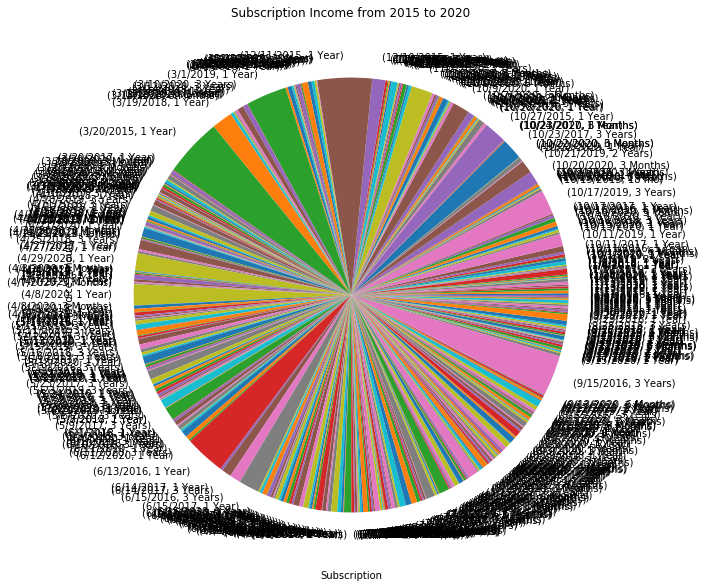

In [49]:
mean_subscription_income = ATLAS.groupby(['Invoice Date', 'Subscription'])["Invoice Amount"].mean()
mean_subscription_income = mean_subscription_income.sort_index()
mean_subscription_income.plot.pie(title="Subscription Income from 2015 to 2020", figsize=(25,10))
plt.xlabel("Subscription")
plt.ylabel("Yearly Invoice Amount")



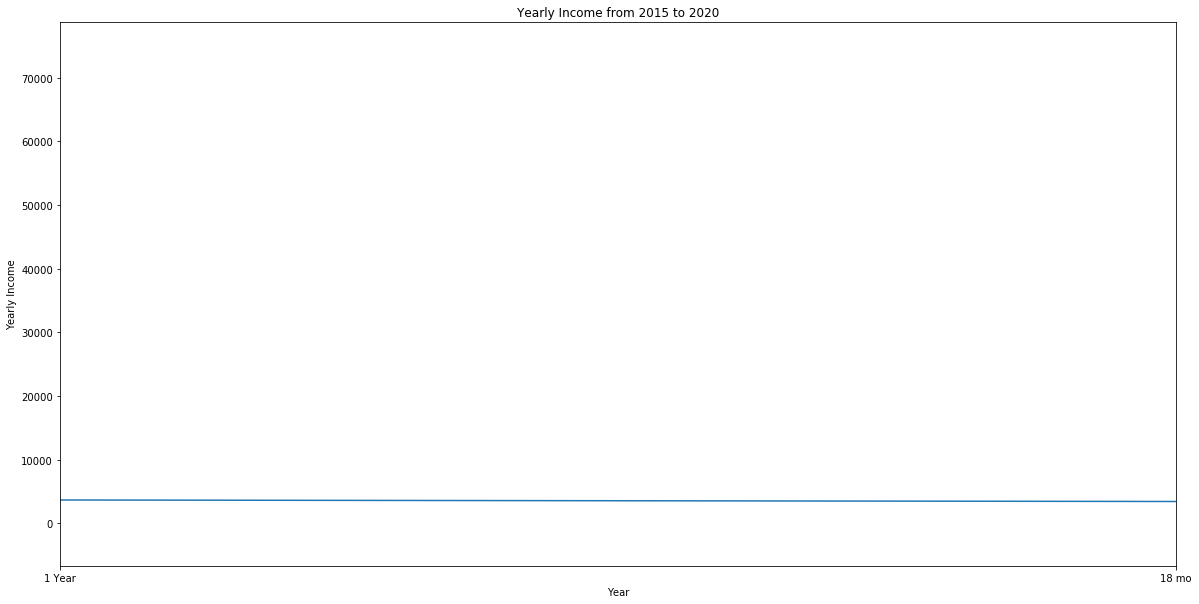

In [35]:
amount_min = ATLAS.groupby(["Subscription"])["Invoice Amount"].min().min()
amount_max = ATLAS.groupby(["Subscription"])["Invoice Amount"].max().max()
amount_std = ATLAS["Invoice Amount"].std()

first_year = mean_subscription_income.index[0]
last_year = mean_subscription_income.index[-1]

fig_subscription_income = mean_subscription_income.plot.line(xlim=[first_year, last_year],
                                                figsize = (20, 10),
                                               ylim=[amount_min - amount_std, amount_max + amount_std])
fig_subscription_income.set_title("Yearly Income from 2015 to 2020")
fig_subscription_income.set_xlabel("Year")
fig_subscription_income.set_ylabel("Yearly Income")

plt.show()

Text(0, 0.5, 'Yearly Invoice Amount')

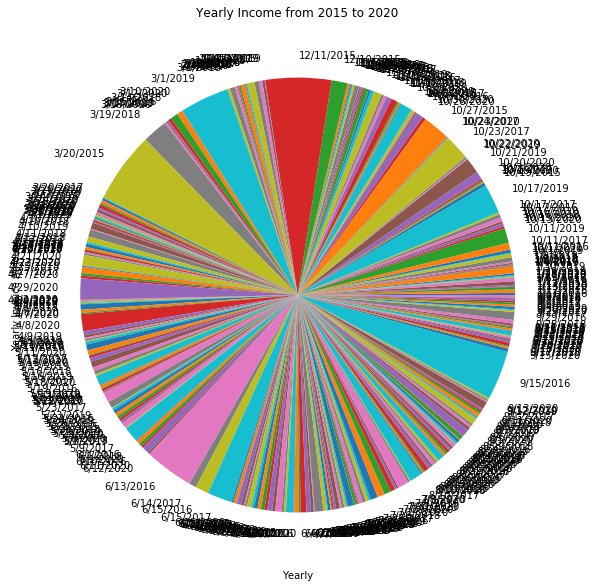

In [36]:
mean_yearly_income = ATLAS.groupby(["Invoice Date"])["Invoice Amount"].mean()
mean_yearly_income = mean_yearly_income.sort_index()
mean_yearly_income.plot.pie(title="Yearly Income from 2015 to 2020", figsize=(25,10))
plt.xlabel("Yearly")
plt.ylabel("Yearly Invoice Amount")

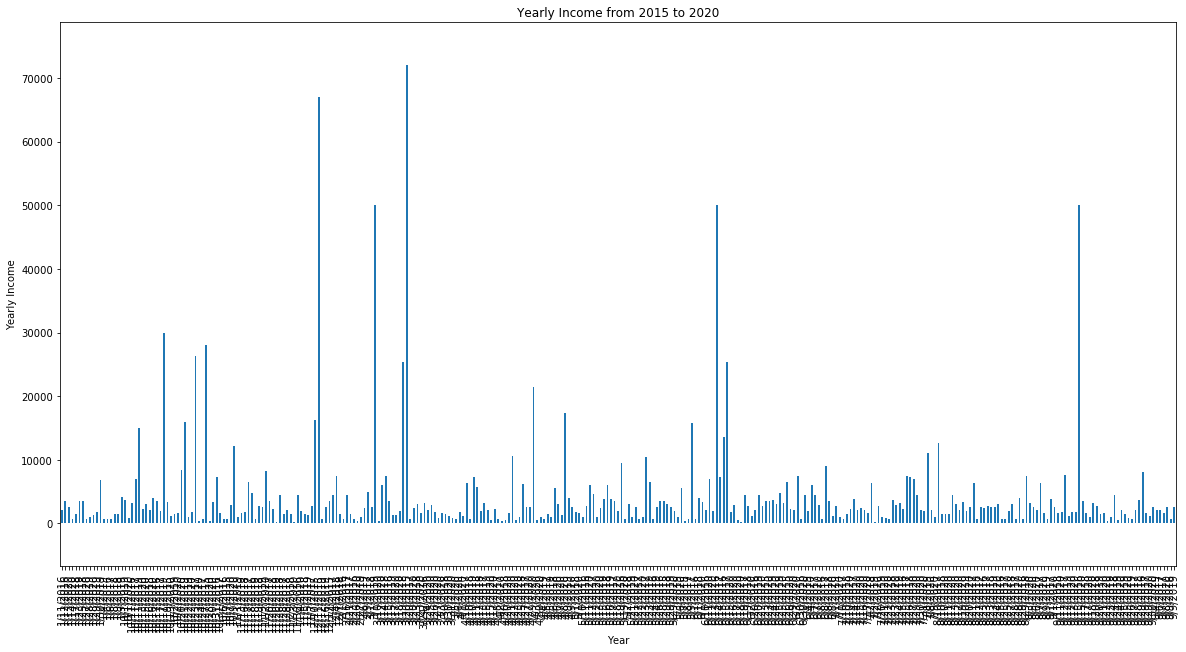

In [37]:
# # Use the Pandas plot function to plot the average Invoice Amount per Year.
# Note: You will need to manually adjust the y limit of the chart using the min and max values from above.
amount_min = ATLAS.groupby(["Invoice Date"])["Invoice Amount"].min().min()
amount_max = ATLAS.groupby(["Invoice Date"])["Invoice Amount"].max().max()
amount_std = ATLAS["Invoice Amount"].std()

first_year = mean_yearly_income.index[0]
last_year = mean_yearly_income.index[-1]

fig_yearly_income = mean_yearly_income.plot.bar(xlim=[first_year, last_year],
                                                figsize = (20, 10),
                                               ylim=[amount_min - amount_std, amount_max + amount_std])
fig_yearly_income.set_title("Yearly Income from 2015 to 2020")
fig_yearly_income.set_xlabel("Year")
fig_yearly_income.set_ylabel("Yearly Income")

plt.show()

In [38]:
# Change date format/type
ATLAS["Invoice Date"] = ATLAS["Invoice Amount"].str.replace('$','')

invoice_date = ATLAS.iloc[0:6]["Dates of service "]

date1 = pd.Timestamp(date1_str, tz="America/New_York").isoformat()


AttributeError: Can only use .str accessor with string values!

In [ ]:
avg_invoice_amount = ATLAS.groupby(["Subscription"])["Invoice Amount"].mean()
#mean_sale_price_sqr_foot = sfo_data.groupby(["year"])["sale_price_sqr_foot"].mean()

#fig_gross_rent = mean_gross_rent.plot.line()
#fig_gross_rent.set_title("Average Gross Rent in San Francisco")
#fig_gross_rent.set_xlabel("Year")
#fig_gross_rent.set_ylabel("Gross Rent")
#plt.show()